In [1]:
#Settings
PAIRED=False
num_principal_components = 30 # (aka r, the number of principal components)

In [25]:
#Imports
from rp import *
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import lin_im2im.pca
import icecream
%config InlineBackend.figure_format='retina'

In [3]:
#Get the images from Domain B (aka X_B, the target domain)
num_images=6000
image_folder_B='data/celeba/img_align_celeba'
images_B_paths=get_all_paths(image_folder_B)
images_B_path_indices=random_batch(range(len(images_B_paths)),num_images)
images_B=load_images(gather(images_B_paths,images_B_path_indices),strict=False,show_progress=False,use_cache=True)
images_B=[as_rgb_image(as_float_image(image)) for image in images_B]
images_B=as_numpy_array(images_B)

In [4]:
#Get the images from Domain A (AKA X_A, the source domain)
if PAIRED:
    images_A=images_B.copy()
else:
    images_A_paths=images_B_paths
    images_A_path_indices=random_batch(list(   set(range(len(images_A_paths)))   -   set(images_B_path_indices)    ),num_images)
    assert not len(set(images_A_path_indices)&set(images_B_path_indices)) , 'There should be no images in common between A and B if not PAIRED'
    images_A=load_images(gather(images_A_paths,images_A_path_indices),strict=False,show_progress=False,use_cache=True)
    images_A=[as_rgb_image(as_float_image(image)) for image in images_A]
    images_A=as_numpy_array(images_A)
    
images_A=as_numpy_array([as_rgb_image(as_grayscale_image(image)) for image in images_A])

In [5]:
#Although not technically nessecary for this algorithm to run, it's easier to read code when both domains have the same number of images
num_images = min(len(images_A),len(images_B))
images_A=images_A[:num_images]
images_B=images_B[:num_images]

In [6]:
assert images_A[0].shape==images_B[0].shape, 'All images should be the same size'
image_height,image_width,image_num_channels=images_A.shape[1:]
image_dimensionality=image_height*image_width*image_num_channels # (aka d, the dimensionality of the input images when turned to vectors)

In [7]:
def image_to_vector(image):
    assert is_image(image)
    return image.reshape(-1)
def vector_to_image(vector):
    return vector.reshape((image_height,image_width,image_num_channels))
def images_to_vectors(images):
    assert isinstance(images,np.ndarray)
    return images.reshape((len(images),-1))
def vectors_to_images(vectors):
    assert isinstance(vectors,np.ndarray)
    return vectors.reshape((len(vectors),image_height,image_width,image_num_channels))
def display_images(images):
    display_image(horizontally_concatenated_images(images))
def display_vectors(vectors):
    display_images(vectors_to_images(vectors))

Image Domain A



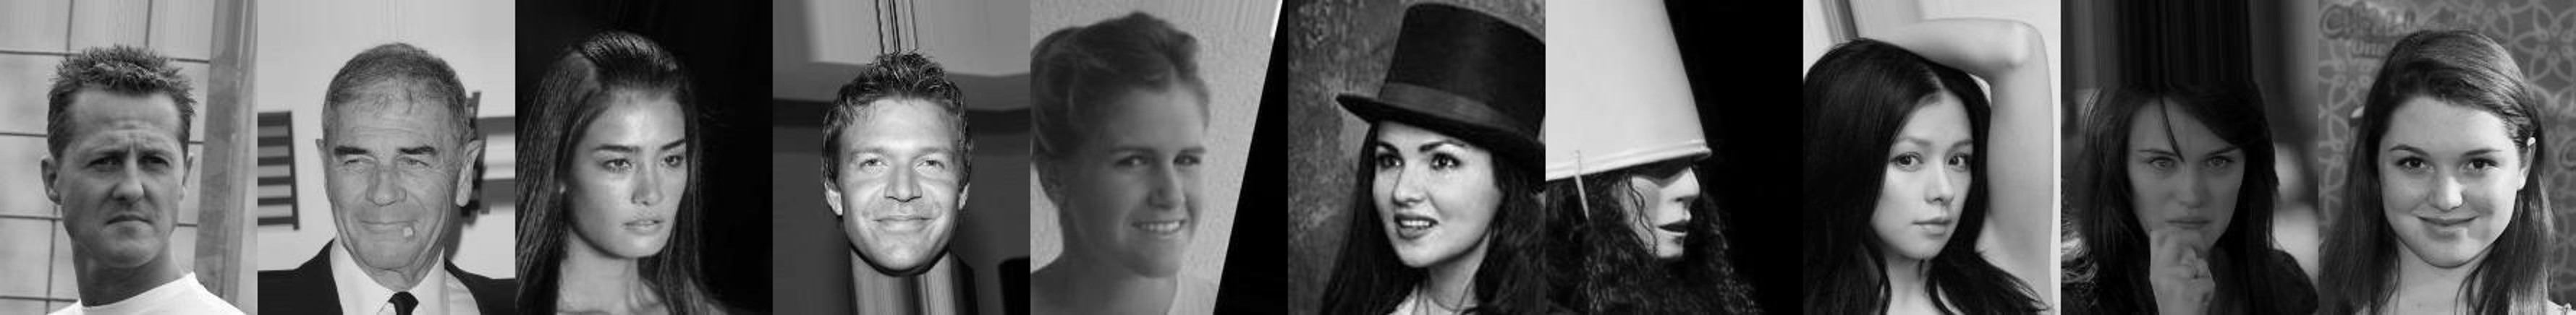

Image Domain B



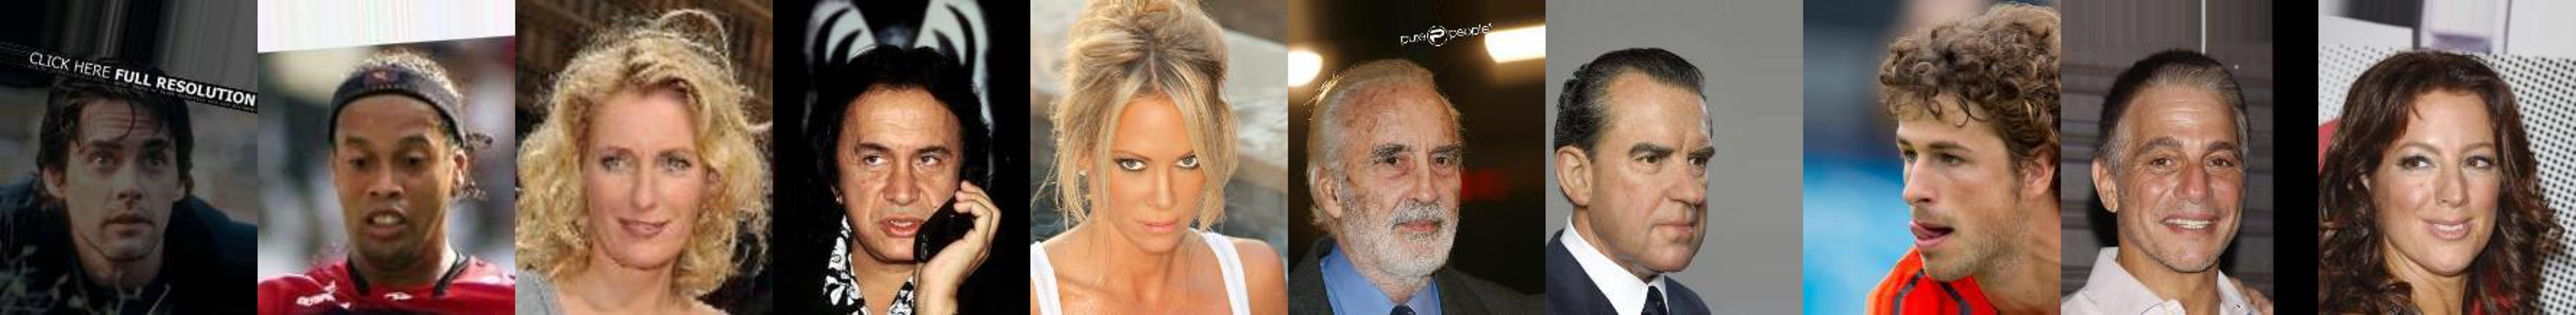

In [8]:
image_display_sample_count=10
image_display_sample_indices=random_batch(range(min(len(images_A),len(images_B))),image_display_sample_count)

print("Image Domain A")
display_images(images_A[image_display_sample_indices])

print("Image Domain B")
display_images(images_B[image_display_sample_indices])

In [9]:
num_principal_components = 300 # (aka r, the number of principal components)
assert num_principal_components <= num_images,'Cannot have more principal components than you do images'
assert num_principal_components <= image_dimensionality,'Cannot have more principal components than there are scalars in an image'
def get_principal_components(vectors):
    assert isinstance(vectors,np.ndarray)
    assert is_a_matrix(vectors)
    # I'm using lin_im2im's author's PCA implementation, becuase it uses GPU acceleration and is orders of magnitude faster than my CPU implementation
    pca=lin_im2im.pca.PCA(num_principal_components) 
    pca.fit(vectors.astype(np.float32))
    return pca.components_

In [10]:
n = num_images
d = image_dimensionality
r = num_principal_components
X_A = images_to_vectors(images_A) - images_A.mean()
X_B = images_to_vectors(images_B) - images_B.mean()
assert X_A.shape==X_B.shape==(n,d)

In [11]:
#Please be patient, this can take a while to calculate
W_A = get_principal_components(X_A)
W_B = get_principal_components(X_B)

# W_A,W_B=lin_im2im.pca.aligned_pca(X_A.astype(np.float32),X_B.astype(np.float32),r)
# W_A=W_A.components_
# W_B=W_B.components_

assert W_A.shape==W_B.shape==(r,d)

Domain A's Principal Components



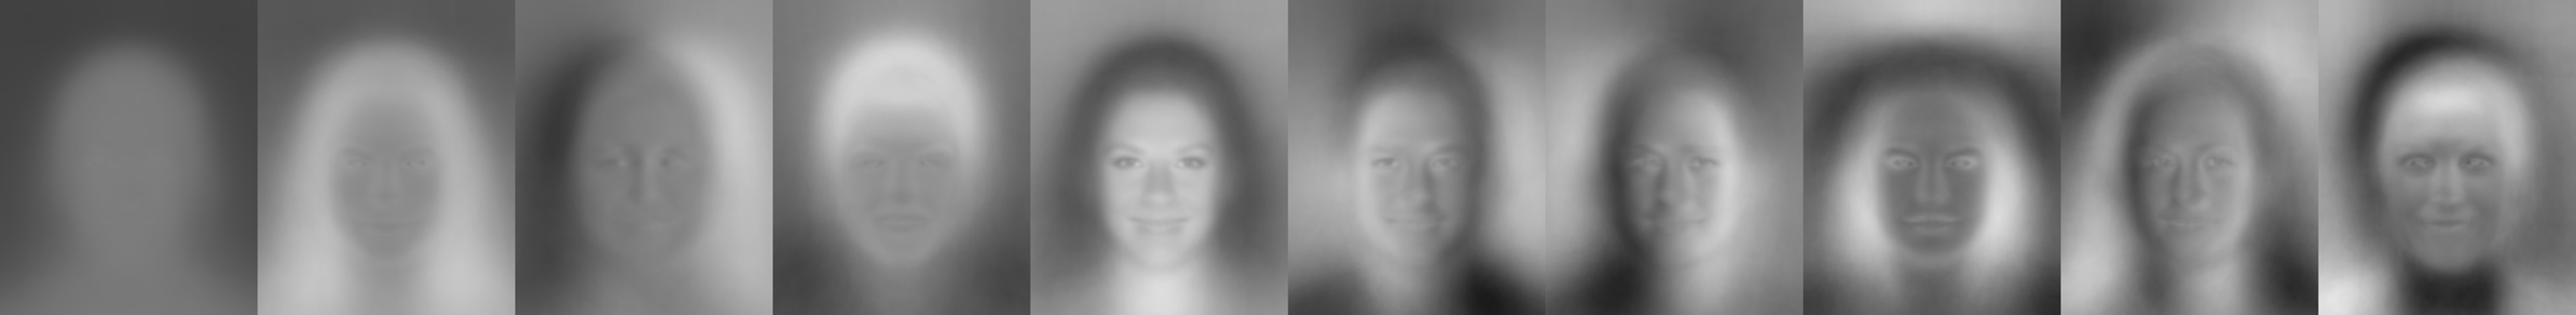

Domain B's Principal Components



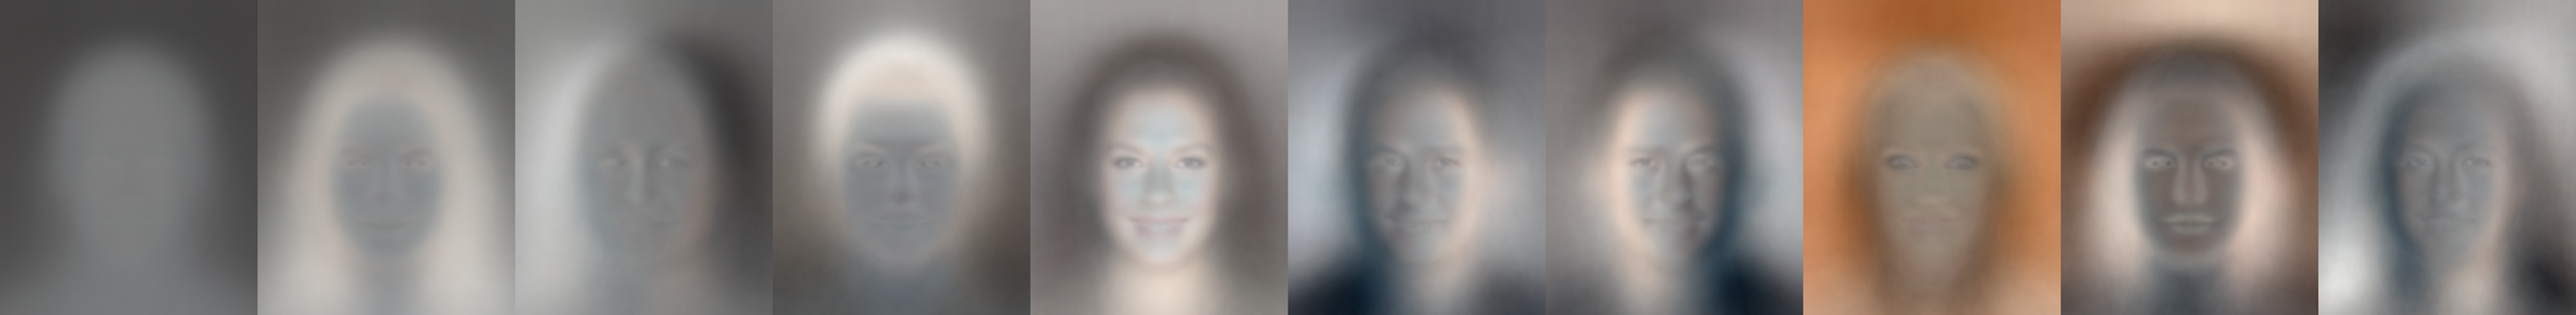

In [12]:
print("Domain A's Principal Components")
display_vectors(50*W_A[:10]+1/2)

print("Domain B's Principal Components")
display_vectors(50*W_B[:10]+1/2)

Hopefully, from the above images, you can see how similar the top eigenvectors are between domains. This is why we suspect it's possible to correlate them between domains; and why the transformation matrix for the embeddings is very close to the identity matrix. For example, when we're looking at faces, perhaps the first two eigen vectors look like girls with long hair, while the 7th looks like a man. Note that some often look inverted in comparison, though - even though they look similar, one face in Domain A might look like it's the inverted image from Domain B. This is where skewness comes in...you'll notice that the ones that are inverted have flipped skews. To see that I mean, take a look at the next few cells...

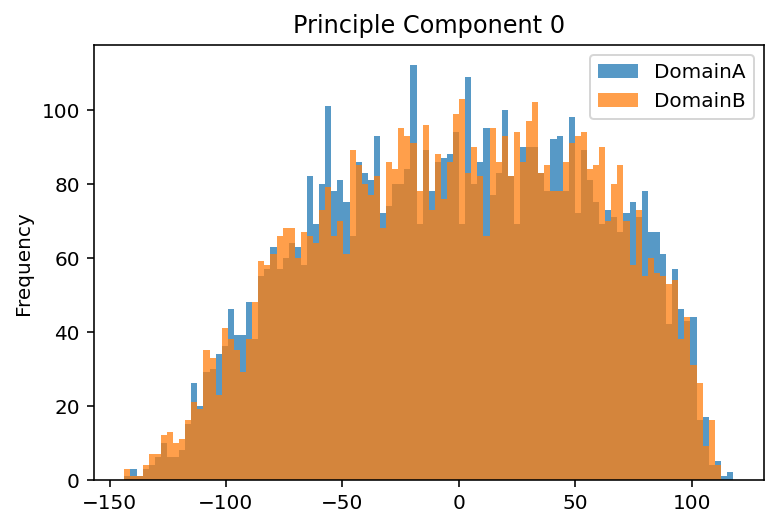

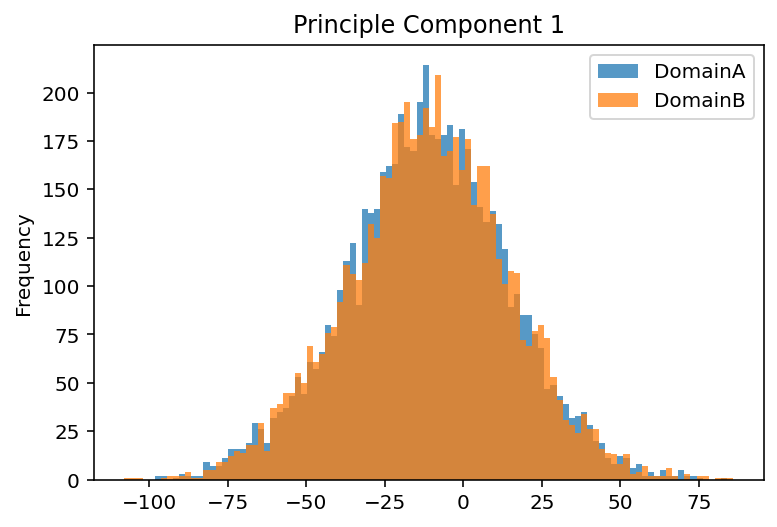

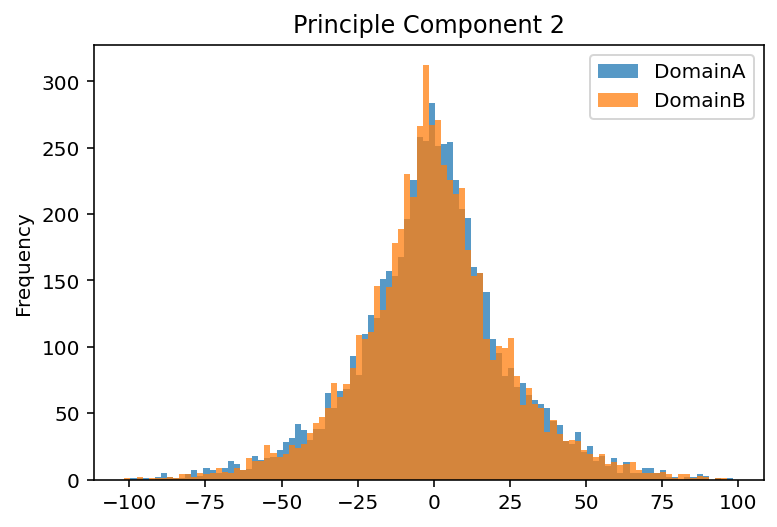

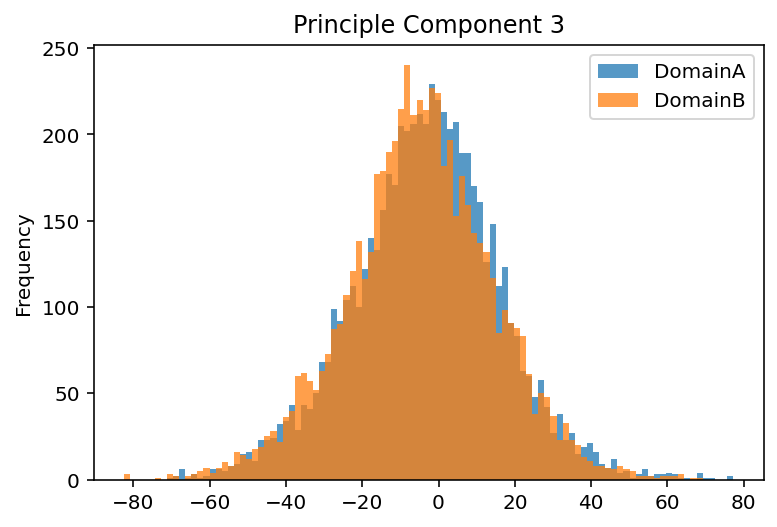

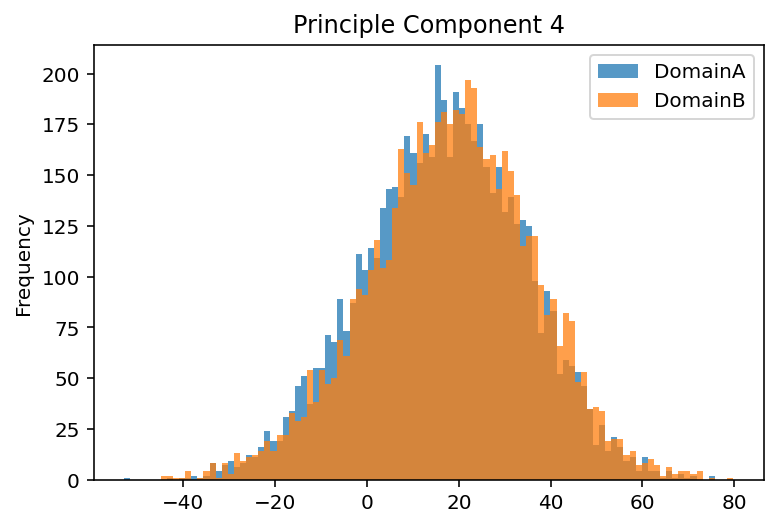

In [26]:
def display_histogram(title='',**kwargs):
    width=300
    pd.DataFrame(kwargs).plot.hist(bins=100,
#                                    range=(-width,width),
                                   alpha=.75,
                                   title=title)
for i in range(5):
    display_histogram(DomainA=W_A[i]@X_A.T,DomainB=W_B[i]@X_B.T,title='Principle Component %i'%i)

In [14]:
skew_A=((W_A@X_A.T)**3).sum(1)
W_A_adjusted=W_A*np.expand_dims(np.sign(skew_A),1)

skew_B=((W_B@X_B.T)**3).sum(1)
W_B_adjusted=W_B*np.expand_dims(np.sign(skew_B),1)


Domain A's Principal Components



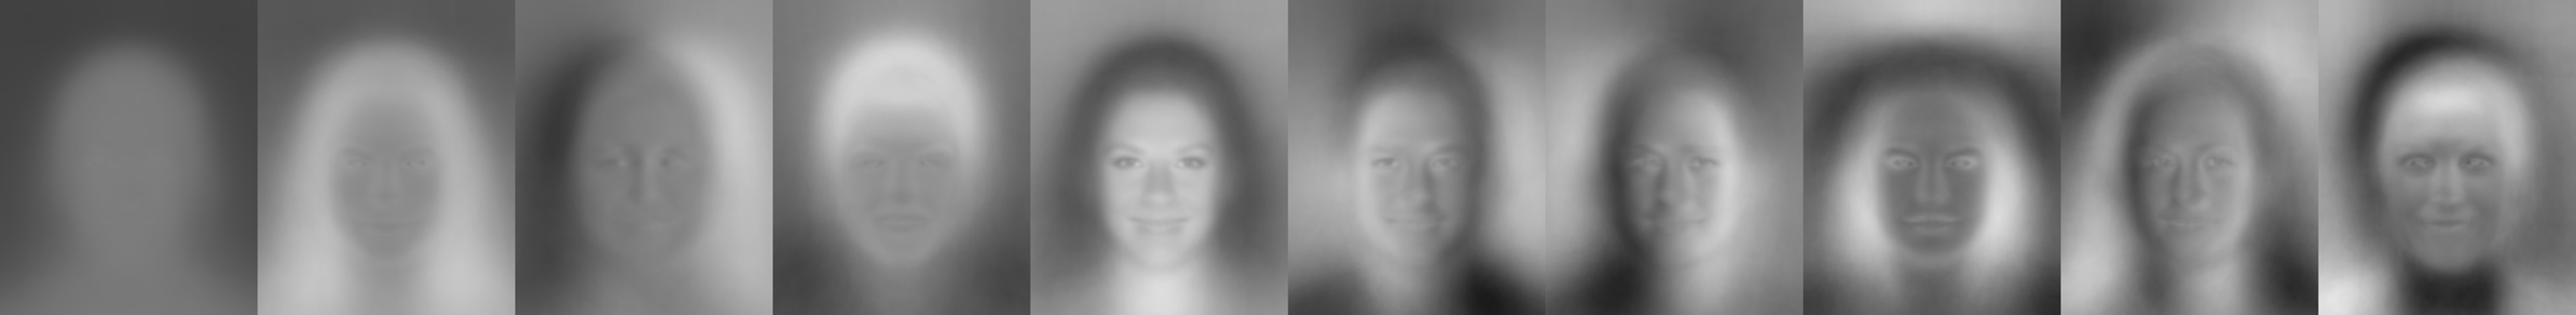

Domain A's Principal Components, Adjusted



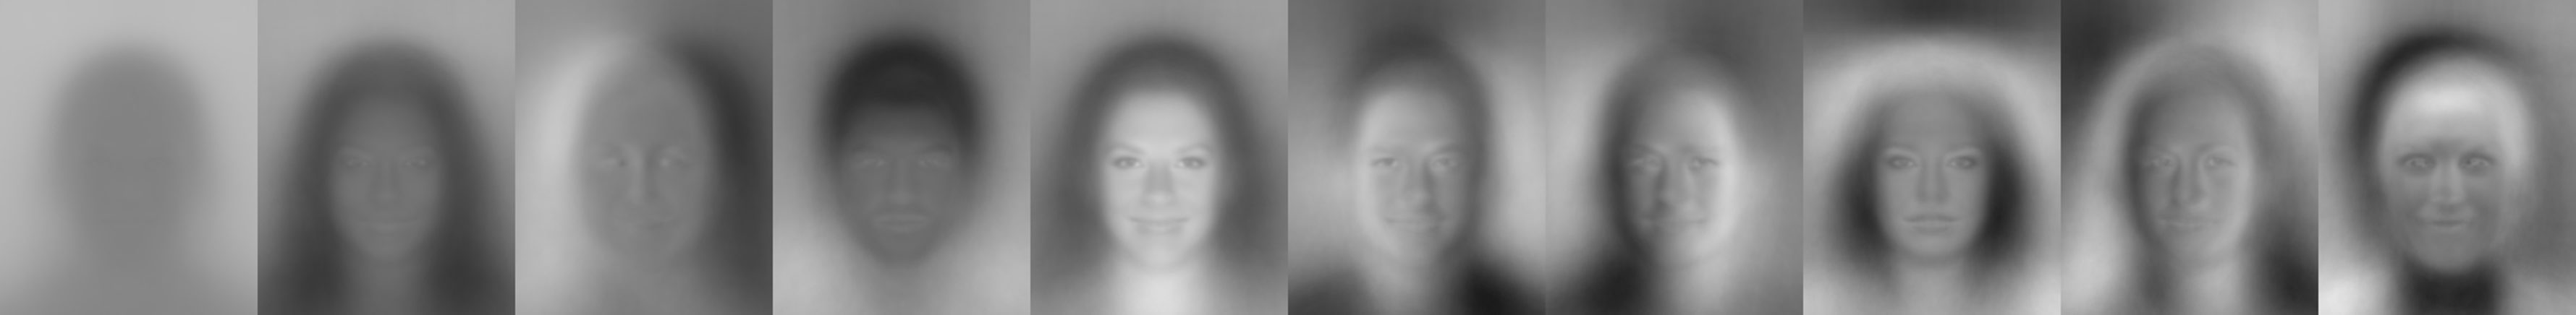

Domain B's Principal Components, Adjusted



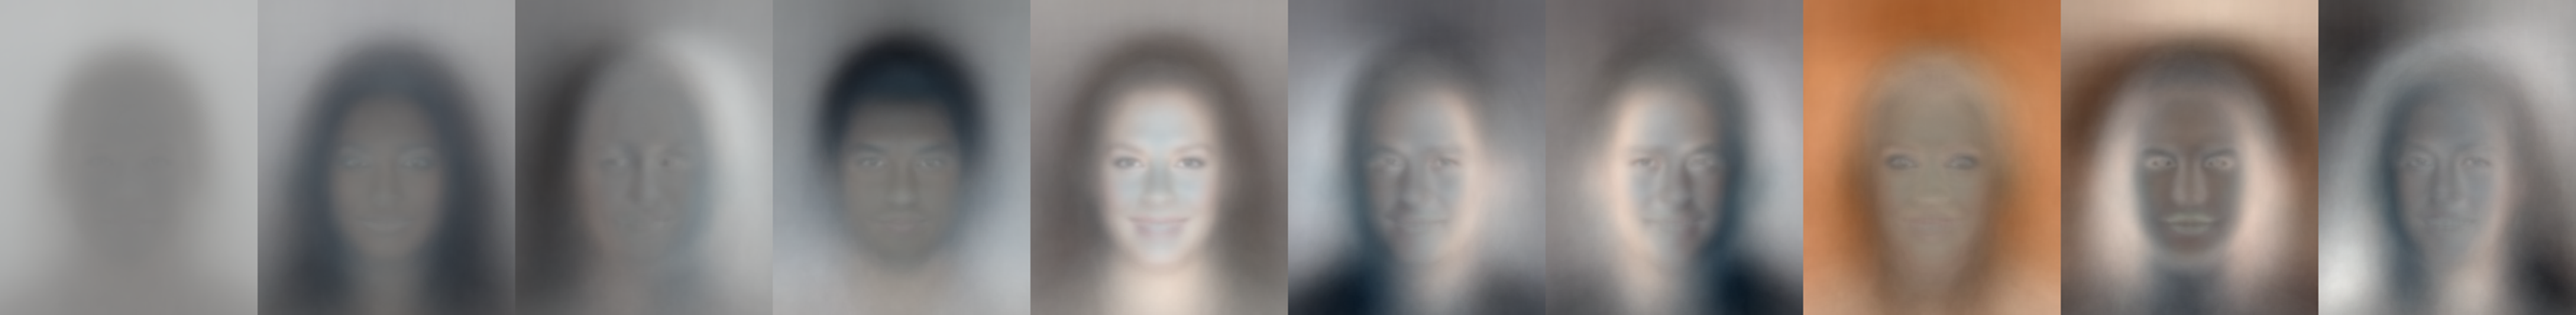

Domain B's Principal Components



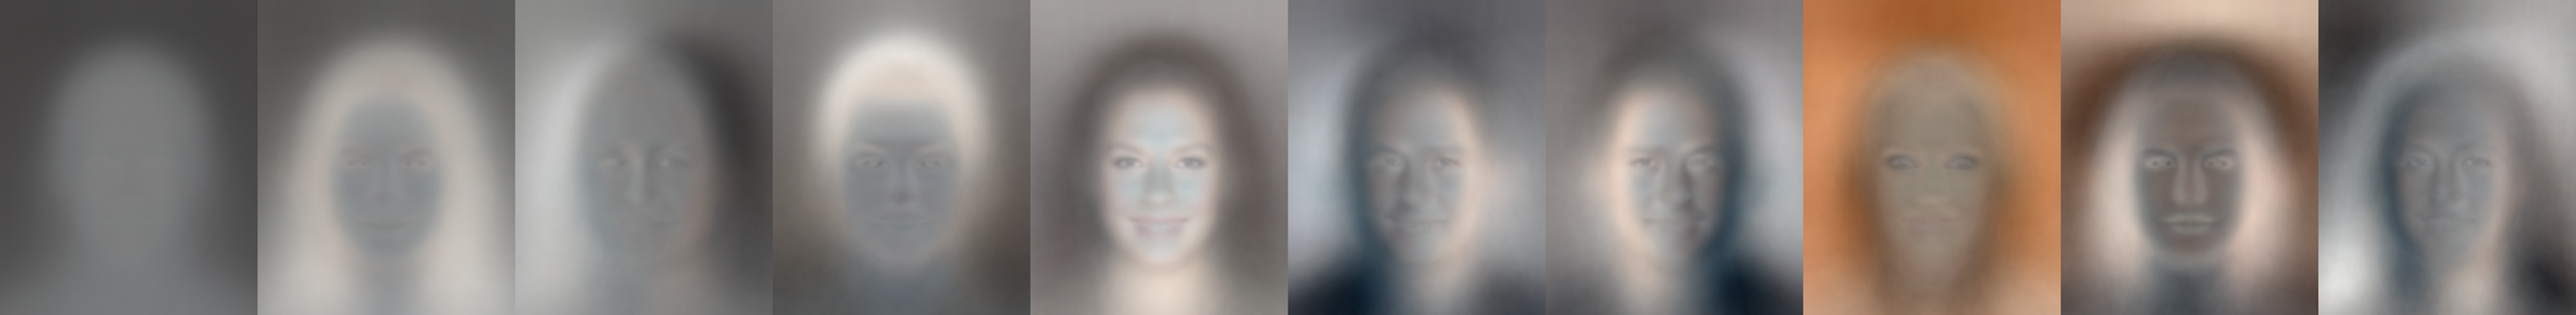

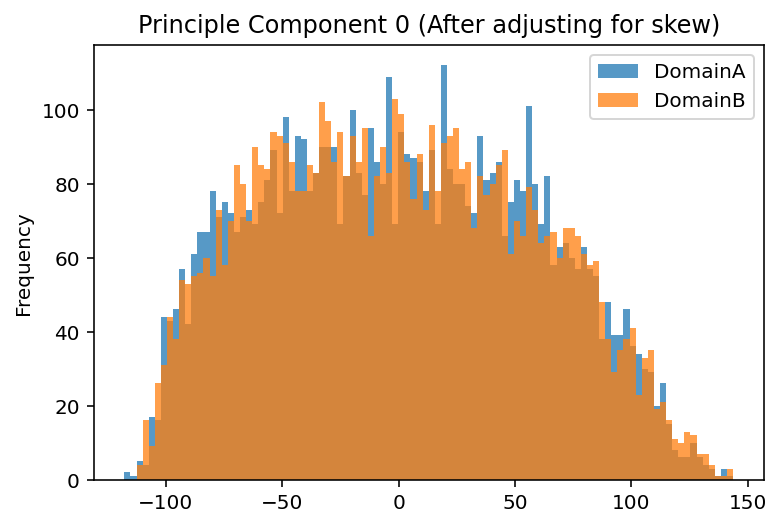

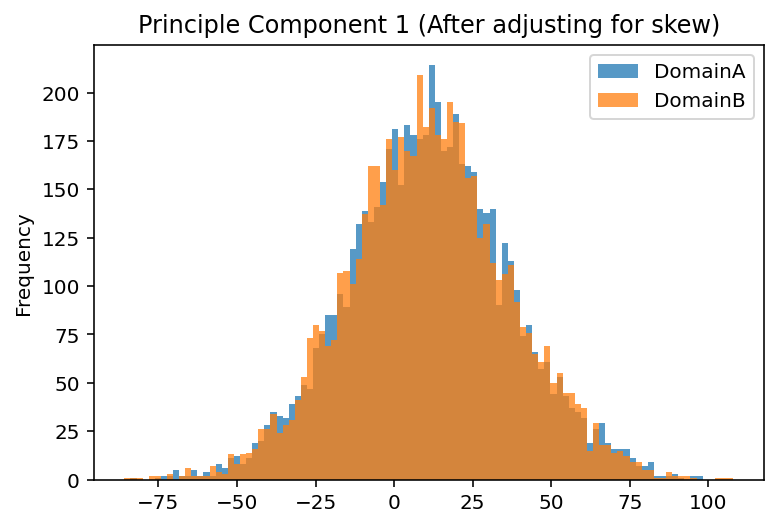

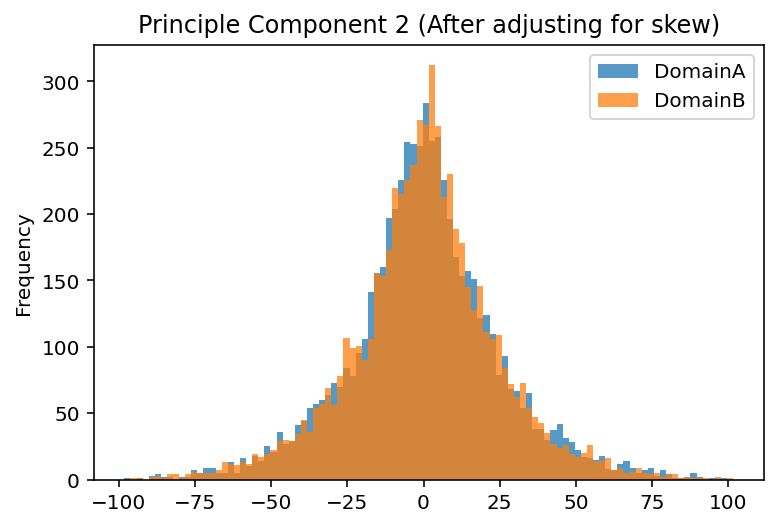

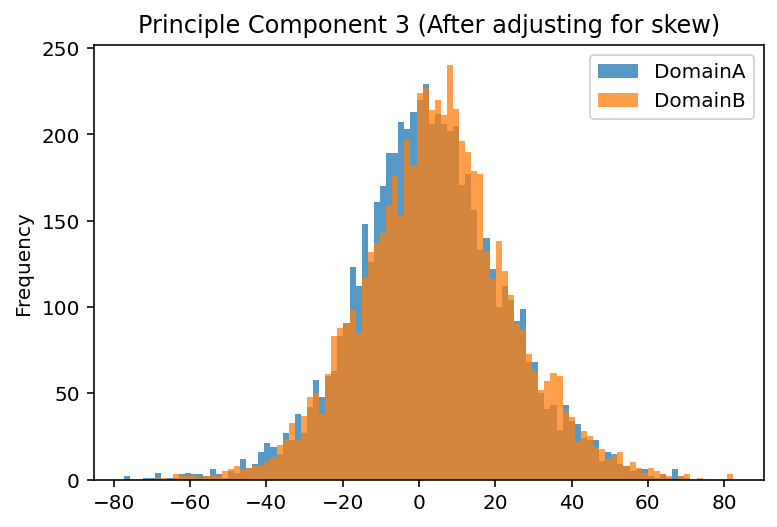

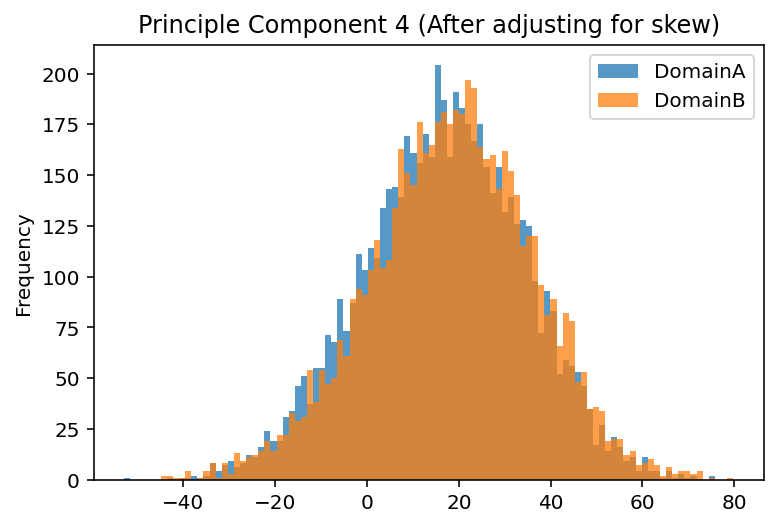

In [27]:
print("Domain A's Principal Components")
display_vectors(50*W_A[:10]+1/2)

print("Domain A's Principal Components, Adjusted")
display_vectors(50*W_A_adjusted[:10]+1/2)

print("Domain B's Principal Components, Adjusted")
display_vectors(50*W_B_adjusted[:10]+1/2)

print("Domain B's Principal Components")
display_vectors(50*W_B[:10]+1/2)

for i in range(5):
    display_histogram(DomainA=W_A_adjusted[i]@X_A.T,DomainB=W_B_adjusted[i]@X_B.T,title='Principle Component %i (After adjusting for skew)'%i)

So, from this analysis, you can see that although their skew heuristic helped, it wasn't perfect. By looking at the eigenvector images, you can see that some of the matches are still flipped wrongly. Although skew might be a good enough heurstic to make a point, I think it's worth trying to find a new way to deal with it. This is an analysis I didn't see in their paper, and when I contacted the author he assumed that only high-order principal components suffered from incorrect flipping.

Domain A's Principal Components



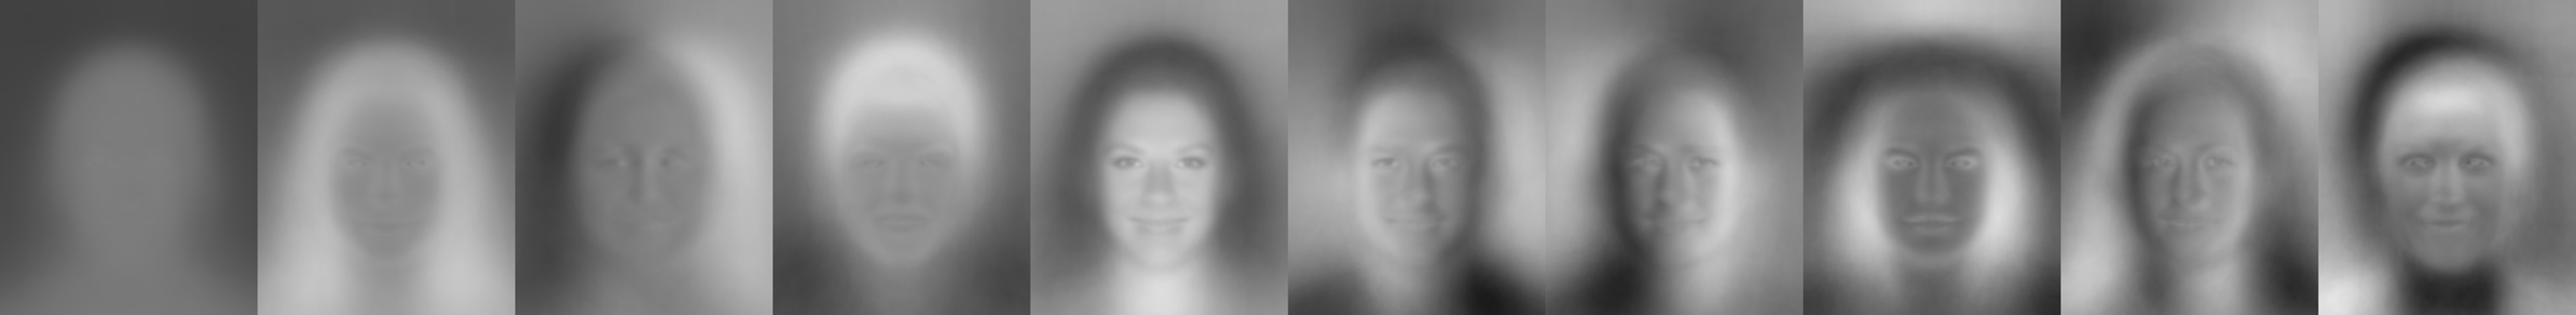

Domain B's Principal Components, Adjusted via Dot-Product-Sign to A



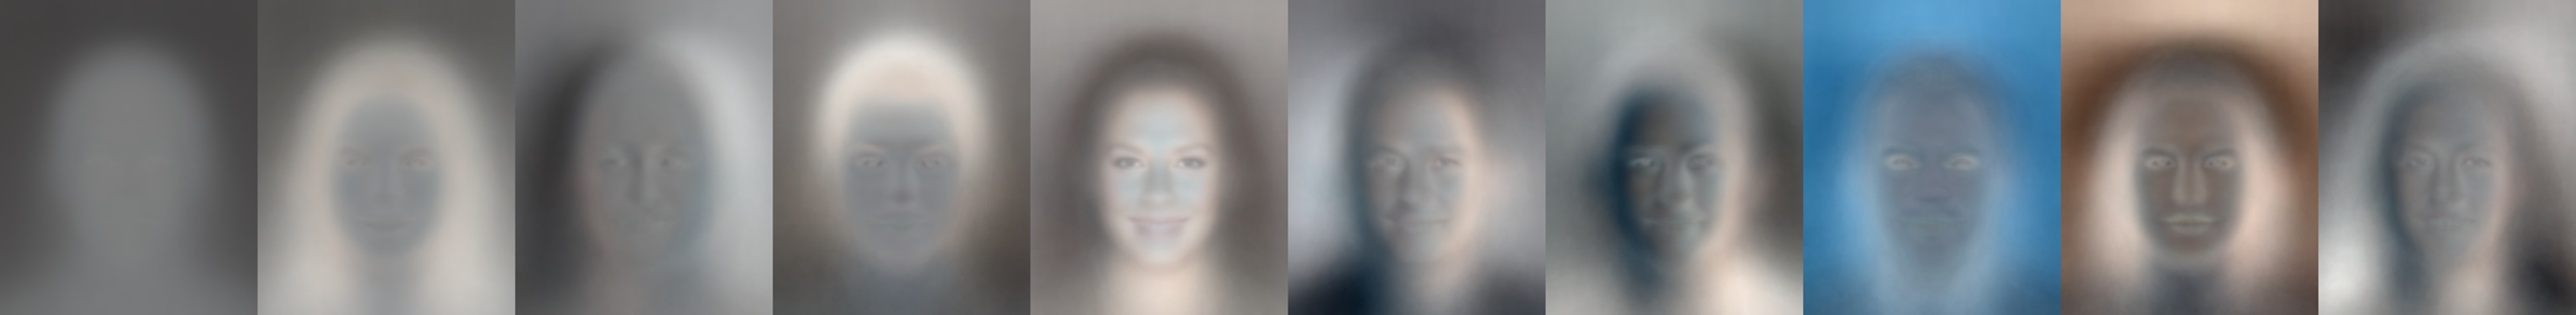

In [16]:
W_B_adjusted_to_A=W_B*np.sign((W_A*W_B).sum(1,keepdims=True))

print("Domain A's Principal Components")
display_vectors(50*W_A[:10]+1/2)

print("Domain B's Principal Components, Adjusted via Dot-Product-Sign to A")
display_vectors(50*W_B_adjusted_to_A[:10]+1/2)

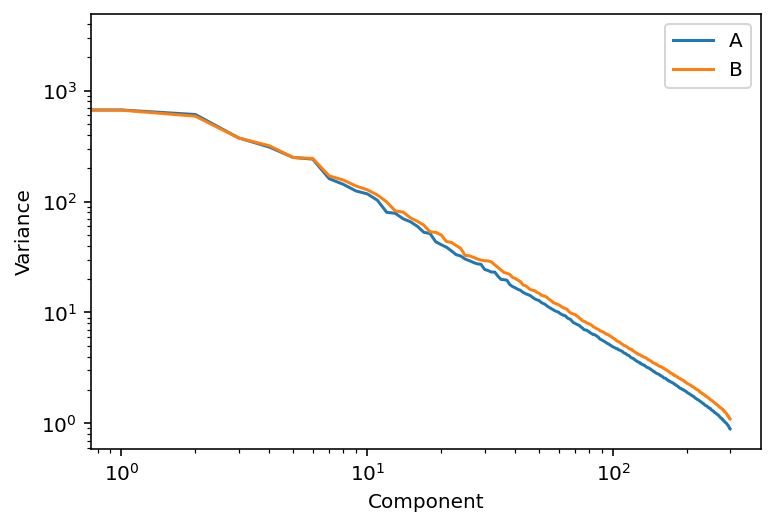

In [28]:
# (W_B_adjusted_to_A.T@W_A@X_A[:10].T).shape
# k=500;display_vectors(full_range(X_A[:10]@W_A[:k].T@W_B_adjusted_to_A[:k]))
pd.DataFrame({'x':range(300),'A':(X_A@W_A.T).var(0)[:300],'B':(X_B@W_B.T).var(0)[:300]}).plot.line(x='x',y=['A','B'],ylabel='Variance',xlabel='Component',loglog=True);


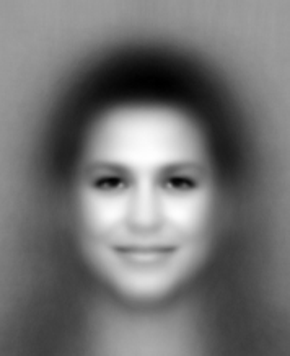

In [18]:
display_vectors(full_range(np.median(X_A,0,keepdims=True)))


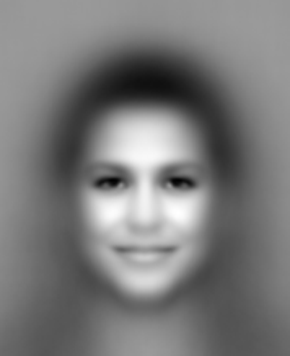

In [19]:

display_vectors(full_range(np.sum(X_A,0,keepdims=True)))


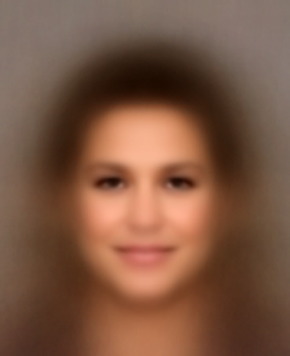

In [20]:

display_vectors(full_range(np.median(X_B,0,keepdims=True)))